In [2]:
# Let's start by defining our helper functions here
!pip install python-chess
import chess
import numpy as np

def one_hot_encode_piece(piece):
    pieces = list('rnbqkpRNBQKP.')
    arr = np.zeros(len(pieces))
    piece_to_index = {p: i for i, p in enumerate(pieces)}
    index = piece_to_index[piece]
    arr[index] = 1
    return arr

def encode_board(board):
    # first lets turn the board into a string
    board_str = str(board)
    # then lets remove all the spaces
    board_str = board_str.replace(' ', '')
    board_list = []
    for row in board_str.split('\n'):
        row_list = []
        for piece in row:
            row_list.append(one_hot_encode_piece(piece))
        board_list.append(row_list)
    return np.array(board_list)




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 4.6 MB/s eta 0:00:00


In [3]:
# We'll use pandas to pull in all our training data
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

file_path = "/content/drive/My Drive/train.csv"

# Read the CSV file into a DataFrame
train_df = pd.read_csv(file_path)

train_df.to_csv("/content/drive/My Drive/train.csv", index=False)

train_df.head()

Mounted at /content/drive


,id,board,black_score,best_move
0,80091,6R1/8/5K2/8/5k2/8/8/2r5 w - - 89 118,0.0,g8d8
1,18578,r1bn1rk1/1p2b1p1/1q2p2p/p2p1p1n/P2P3P/2PB1N2/1...,-131.0,f3e5
2,11580,r2qkb1r/2p2pp1/p1n2nP1/1p1p3p/P7/1Q5b/1PP1PPB1...,-490.0,g6f7
3,72805,8/4kp2/R6p/8/4K3/8/8/8 b - - 7 85,-574.0,h6h5
4,74310,8/8/k7/4R3/8/6K1/8/1r6 w - - 99 90,0.0,e5e6


In [19]:
# In order to tell what phase of the game we're in,
# we can count the total "points of material" on the board.
# If there are lots of pieces left of the board,
# we're probably in the opening, and if we only have a few left,
# we're probably near the endgame.

def count_material(fen):
    total_material = 0
    material_dict = {
        'p': 1,
        'b': 3,
        'n': 3,
        'r': 5,
        'q': 9
    }
    for char in fen.lower():
        if char in material_dict:
            total_material += material_dict[char]

    return total_material

train_df['total_material'] = train_df['board'].apply(count_material)

In [20]:
# Let's break our training data into each of our phases
endgame_df = train_df[train_df['total_material'] < 30]
midgame_df = train_df[(30 <= train_df['total_material']) & (train_df['total_material'] <= 60)]
opening_df = train_df[(60 < train_df['total_material']) & (train_df['total_material'] <= 78)]

In [21]:
import numpy as np
def encode_fen_string(fen_str):
    board = chess.Board(fen=fen_str)
    return encode_board(board)

In [22]:
# One function to rule them all
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def generate_model(data_to_train_on, model_name):
    val_df = data_to_train_on[-1000:]
    train_df = data_to_train_on[:55000]

    X_train = np.stack(train_df['board'].apply(encode_fen_string))
    y_train = train_df['black_score']

    X_val = np.stack(val_df['board'].apply(encode_fen_string))
    y_val = val_df['black_score']

    model = Sequential([
        Flatten(),
        Dense(768, activation='relu'),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dense(256, activation='linear'),
        BatchNormalization(),
        Dense(1),
    ])

    model.compile(
        optimizer='rmsprop',
        loss='mean_squared_error')

    # Using EarlyStopping and ReduceLROnPlateau callbacks
    callbacks = [
        EarlyStopping(patience=5, restore_best_weights=True),  # Early stopping
        ReduceLROnPlateau(factor=0.5, patience=3)  # Reduce learning rate on plateau
    ]

    # Training the model with callbacks
    history = model.fit(
        X_train,
        y_train,
        epochs=100,
        validation_data=(X_val, y_val),
        callbacks=callbacks)

    import matplotlib.pyplot as plt

    # Plotting the training history
    plt.style.use('ggplot')
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.legend()
    plt.title('Loss During Training')
    plt.show()

    # Save the model
    model.save('/content/drive/My Drive/' + model_name + '.h5')

    return model



Epoch 1/50
786/786 [==============================] - 9s 6ms/step - loss: 132635.9531 - val_loss: 79569.3047 - lr: 0.0010
Epoch 2/50
786/786 [==============================] - 4s 5ms/step - loss: 92006.3516 - val_loss: 68056.4297 - lr: 0.0010
Epoch 3/50
786/786 [==============================] - 4s 5ms/step - loss: 81194.7031 - val_loss: 66142.1797 - lr: 0.0010
Epoch 4/50
786/786 [==============================] - 5s 6ms/step - loss: 73625.6406 - val_loss: 56296.5312 - lr: 0.0010
Epoch 5/50
786/786 [==============================] - 4s 5ms/step - loss: 69410.7031 - val_loss: 54673.0430 - lr: 0.0010
Epoch 6/50
786/786 [==============================] - 4s 5ms/step - loss: 65600.9922 - val_loss: 48300.2695 - lr: 0.0010
Epoch 7/50
786/786 [==============================] - 5s 6ms/step - loss: 62493.2695 - val_loss: 62345.3008 - lr: 0.0010
Epoch 8/50
786/786 [==============================] - 4s 5ms/step - loss: 61280.4883 - val_loss: 51758.3281 - lr: 0.0010
Epoch 9/50
786/786 [===========

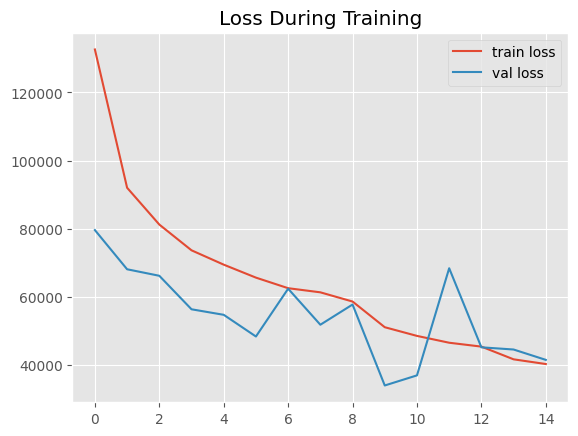

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Let's train on our endgame data to generate an endgame model
endgame_model = generate_model(endgame_df, 'endgame_model')

Epoch 1/50
516/516 [==============================] - 4s 5ms/step - loss: 135283.0312 - val_loss: 93504.0625 - lr: 0.0010
Epoch 2/50
516/516 [==============================] - 3s 6ms/step - loss: 78601.1484 - val_loss: 68388.5781 - lr: 0.0010
Epoch 3/50
516/516 [==============================] - 3s 6ms/step - loss: 64443.2578 - val_loss: 53124.8906 - lr: 0.0010
Epoch 4/50
516/516 [==============================] - 3s 5ms/step - loss: 57670.2695 - val_loss: 59018.9805 - lr: 0.0010
Epoch 5/50
516/516 [==============================] - 3s 5ms/step - loss: 52475.4102 - val_loss: 52220.5195 - lr: 0.0010
Epoch 6/50
516/516 [==============================] - 3s 5ms/step - loss: 49110.1992 - val_loss: 53571.5703 - lr: 0.0010
Epoch 7/50
516/516 [==============================] - 3s 6ms/step - loss: 46899.7227 - val_loss: 47883.1055 - lr: 0.0010
Epoch 8/50
516/516 [==============================] - 3s 6ms/step - loss: 44770.8438 - val_loss: 35724.5195 - lr: 0.0010
Epoch 9/50
516/516 [===========

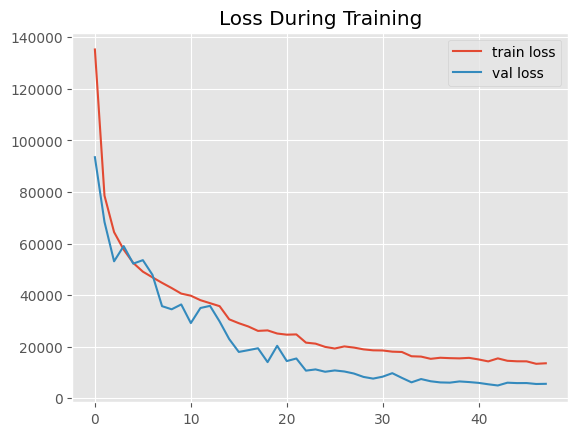

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Let's train on our midgame data to generate an midgame model
midgame_model = generate_model(midgame_df, 'midgame_model')

Epoch 1/50
244/244 [==============================] - 3s 6ms/step - loss: 131894.3125 - val_loss: 123740.7422 - lr: 0.0010
Epoch 2/50
244/244 [==============================] - 1s 5ms/step - loss: 86431.3359 - val_loss: 65906.4844 - lr: 0.0010
Epoch 3/50
244/244 [==============================] - 2s 7ms/step - loss: 54255.5312 - val_loss: 46563.4727 - lr: 0.0010
Epoch 4/50
244/244 [==============================] - 2s 7ms/step - loss: 42365.9883 - val_loss: 47405.6719 - lr: 0.0010
Epoch 5/50
244/244 [==============================] - 1s 5ms/step - loss: 38841.2344 - val_loss: 34062.7617 - lr: 0.0010
Epoch 6/50
244/244 [==============================] - 1s 5ms/step - loss: 36589.5625 - val_loss: 31964.4277 - lr: 0.0010
Epoch 7/50
244/244 [==============================] - 1s 5ms/step - loss: 33029.4023 - val_loss: 29774.7344 - lr: 0.0010
Epoch 8/50
244/244 [==============================] - 1s 5ms/step - loss: 31267.5918 - val_loss: 31363.4648 - lr: 0.0010
Epoch 9/50
244/244 [==========

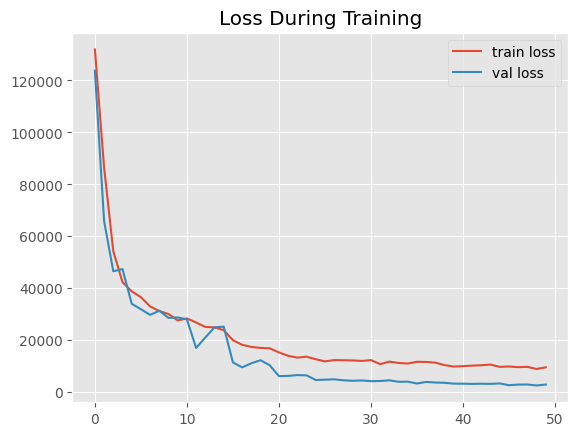

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Let's train on our opening data to generate an opening model
opening_model = generate_model(opening_df, 'opening_model')

In [23]:
import os
from tensorflow.keras.models import load_model

# Define function to load model from Google Drive
def load_model_from_drive(model_path):
    # Assuming model_path is the path in your Google Drive where the model is stored
    # You should replace this with the actual path in your Google Drive
    drive_model_path = '/content/drive/My Drive/' + model_path
    if os.path.exists(drive_model_path):
        # Load the model from Google Drive
        loaded_model = load_model(drive_model_path)
        return loaded_model
    else:
        print("Model file not found in Google Drive.")
        return None

# Load models from Google Drive
endgame_model = load_model_from_drive("endgame_model.h5")
midgame_model = load_model_from_drive("midgame_model.h5")
opening_model = load_model_from_drive("opening_model.h5")

In [24]:
def play_nn(fen, depth=2):
    def evaluate(board):
        material = count_material(str(board))
        encoded_board = encode_board(board)
        reshaped_board = encoded_board.reshape(1, 8, 8, 13)
        if material < 30:
            return endgame_model.predict(reshaped_board)[0][0]
        elif material < 60:
            return midgame_model.predict(reshaped_board)[0][0]
        else:
            return opening_model.predict(reshaped_board)[0][0]

    def minimax(board, depth, alpha, beta, maximizing_player):
        if depth == 0 or board.is_game_over():
            return evaluate(board)

        legal_moves = list(board.legal_moves)

        if maximizing_player:
            max_eval = float('-inf')
            for move in legal_moves:
                board.push(move)
                eval = minimax(board, depth - 1, alpha, beta, False)
                board.pop()
                max_eval = max(max_eval, eval)
                alpha = max(alpha, eval)
                if beta <= alpha:
                    break  # Beta cutoff
            return max_eval
        else:
            min_eval = float('inf')
            for move in legal_moves:
                board.push(move)
                eval = minimax(board, depth - 1, alpha, beta, True)
                board.pop()
                min_eval = min(min_eval, eval)
                beta = min(beta, eval)
                if beta <= alpha:
                    break  # Alpha cutoff
            return min_eval

    best_move = None
    best_score = float('-inf')
    alpha = float('-inf')
    beta = float('inf')

    board = chess.Board(fen=fen)
    legal_moves = list(board.legal_moves)

    for move in legal_moves:
        board.push(move)
        eval = minimax(board, depth - 1, alpha, beta, False)
        board.pop()
        if eval > best_score:
            best_score = eval
            best_move = move
        alpha = max(alpha, eval)

    return str(best_move)


In [25]:
# Let's play against it!
# To make it easy to code up we'll always play as white.
from IPython.display import SVG, display

# Our play function accepts whatever strategy our AI is using, like play_random from above
def play_game(ai_function):
    board = chess.Board()

    while board.outcome() is None:
        # We print out the board as an SVG
        display(SVG(board._repr_svg_()))

        # If it's white's turn, we have the user play
        if board.turn == chess.WHITE:
            user_move = input('Your move: ')
            if user_move == 'quit':
                break
            # The move a user puts in isn't a valid move, we keep prompting them for a valid move
            while user_move not in [str(move) for move in board.legal_moves]:
                print('That wasn\'t a valid move. Please enter a move in Standard Algebraic Notation')
                user_move = input('Your move: ')
            board.push_san(user_move)

        # If it's black's turn, we have the AI play
        elif board.turn == chess.BLACK:
            ai_move = ai_function(board.fen())
            print(f'AI move: {ai_move}')
            board.push_san(ai_move)

    print(board.outcome())



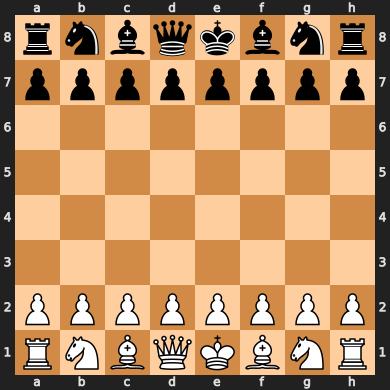

In [ ]:
play_game(play_nn)